## Library Setup

### Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using MinMaxScaler__</mark>
 - <mark>__Group By binary Literal__</mark>
 - <mark>__Generated A Normal Rank for all Ordinal Features__</mark>
 - <mark>__Generated Dummy Variable for categoricals__</mark>
 - <mark>__Made all Type Conversions__</mark>


In [1]:
# import widen_notebook
from mysetup import NotebookFinder
import sys

sys.meta_path.append(NotebookFinder())

from setup_transform import *

%matplotlib inline
cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
lgr_params = dict(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=True,
    multi_class="ovr",
    max_iter=200000,
    random_state=42,
    n_jobs=24,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=30),
    scoring="f1_macro",
    solver="saga",
    Cs=100,
    l1_ratios=np.linspace(0, 1, endpoint=False, num=10),
)
def_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)
from sklearnex import unpatch_sklearn

unpatch_sklearn()

importing Jupyter notebook from setup_transform.ipynb


/home/u164131/.conda/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
raw_norm = Normalizer().fit_transform(
    raw_data.loc[:, [x for x in raw_data_eval.columns if ("nominal" not in x)]]
)
norm_df = pd.DataFrame(
    raw_norm, columns=[x for x in raw_data_eval.columns if ("nominal" not in x)]
)

In [4]:
import copy


N_BINS =30
y = raw_data.target
# X_train,X_test,y_train,y_test = gen_train_test(X,y,test_size=0.3)
class_frequency = raw_data.target.value_counts(normalize=True)
CLS_PRIOR = np.array(list(class_frequency.to_dict().values()))
ordinal_unmod = copy.deepcopy(ordinal) 
ordinal_unmod.remove('ordinal__norm')
X = ordinal_data.loc[:,ordinal_unmod]
kbins_ordinal = KBinsDiscretizer(n_bins=N_BINS,encode='ordinal',subsample=None,strategy='kmeans',random_state=42)
kbins_onehot = sklearn.base.clone(kbins_ordinal).set_params().set_params(encode='onehot-dense')

all_data = pd.concat([ordinal_data,ordinal_data_eval], ignore_index=True,axis=0)
needed_data = all_data.loc[:,ordinal_unmod]
y = None # Unsupervised
encoders = {'ordinal_output': make_pipeline(kbins_ordinal,VarianceThreshold(0.0001)),
           'ohe_dense_output':make_pipeline(kbins_onehot,VarianceThreshold(0.0001))}
X_transformed={}
for enc in encoders:
    encoders[enc].fit(needed_data)
    X_enc = encoders[enc].transform(X)
    X_transformed[enc]= X_enc

ensemble = DecisionTreeClassifier(class_weight=CLASS_WEIGHTS,max_depth=6,random_state=42,)
linear_estimator = LogisticRegression(class_weight=CLASS_WEIGHTS,max_iter=100000,random_state=42)
linear_estimator = LogisticRegressionCV(**lgr_params)
binary_learner = BernoulliNB(binarize=None,alpha=0,class_prior=CLS_PRIOR)
clf_metrics = ['f1_macro','balanced_accuracy','roc_auc_ovr']
y = raw_data.target

validation_config = dict(y = raw_data.target,cv = def_cv,n_jobs=-1,scoring=clf_metrics,return_train_score=True,pre_dispatch='2*n_jobs')


X = ordinal_data
    
estimators = [ensemble,binary_learner,linear_estimator]
y = raw_data.target
with parallel_backend('loky',n_jobs=24):
    clf_scores_3 = cross_validate(linear_estimator,X_transformed['ohe_dense_output'],**validation_config)
with parallel_backend('loky',n_jobs=24):
    clf_scores_1 = cross_validate(ensemble,X_transformed['ordinal_output'],**validation_config)
    clf_scores_2 = cross_validate(binary_learner,X_transformed['ohe_dense_output'],**validation_config)

effs = [clf_scores_1,clf_scores_2,clf_scores_3]

def plot_results(data,ax_):
    global clf_metrics
    score_types = ['train', 'test']
    #     metrics = ['f1_macro','balanced_accuracy','roc_auc_ovr']
    metrics = copy.deepcopy(clf_metrics)
    total_plots = len(score_types)*len(metrics)
    layout = (len(metrics),1)
    folds = len(data)
#         bounds = (data[r_key[0]],data[r_key[1]])
    for metric in metrics:
        train_, test_ =  tuple([score_type+metric for score_type in score_types])
        
        
        ax_.plot(folds,data[train_],data[test_], label=f'Training Metric: {metric}')
        ax_.plot(folds,data[test_], label=f'Prediction Metric: {metric}')
        ax_.text(f'Mean: {data[train_].mean()}\n Mean: {data[test_].std()}')
        ax_.fill_between(
            np.arange(folds),
            data[train_],
            data[test_],
            alpha=0.2,
            color="darkorange",
            lw=lw,
        )
fig, ax =  plt.subpl
for 



In [9]:
tuple([i for i in range(10)])

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [5]:
# X_transformed['ohe_dense_output'].shape
clf_scores_3 = cross_validate(
    linear_estimator, X_transformed["ohe_dense_output"], **validation_config
)

In [7]:
clf_scores_3["test_f1_macro"].std()

0.010927589986640347

In [ ]:
# fig, ax = plt.subplots(3,1,figsize=(10,10))

### Ordinal Contrast Encoding

In [65]:
import statsmodels.api as sm
from patsy.contrasts import Treatment
from statsmodels.formula.api import ols
from patsy.contrasts import ContrastMatrix
from patsy.contrasts import *

ordinal_poly.columns[1:]

Index(['ordinal__v_0_0', 'ordinal__v_0_1', 'ordinal__v_0_2', 'ordinal__v_0_3',
       'ordinal__v_0_4', 'ordinal__v_0_5', 'ordinal__v_0_6', 'ordinal__v_0_7',
       'ordinal__v_0_8', 'ordinal__v_0_9',
       ...
       'ordinal__v_6_10', 'ordinal__v_6_11', 'ordinal__v_6_12',
       'ordinal__v_6_13', 'ordinal__v_6_14', 'ordinal__v_6_15',
       'ordinal__v_6_16', 'ordinal__v_6_17', 'ordinal__v_6_18',
       'ordinal__v_6_19'],
      dtype='object', length=338)

In [ ]:
from category_encoders import PolynomialEncoder
from category_encoders.wrapper import PolynomialWrapper as PW

y = raw_data.target

cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
lgr_params = dict(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=True,
    multi_class="ovr",
    max_iter=200000,
    random_state=42,
    n_jobs=24,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=30),
    scoring="f1_macro",
    solver="saga",
    Cs=100,
)


# clf.fit(raw_data.loc[:,ordinal[:-1]],raw_data.target)

In [ ]:
from category_encoders import PolynomialEncoder
from category_encoders.wrapper import PolynomialWrapper as PW

y = raw_data.target

cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
lgr_params = dict(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=True,
    multi_class="multinomial",
    max_iter=20000,
    random_state=42,
    n_jobs=24,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=30),
    scoring="f1_macro",
    solver="liblinear",
    Cs=100,
)
encoder = PolynomialEncoder(cols=ordinal[:-1])
lgr_params["solver"] = "saga"
lgr_params["l1_ratios"] = np.linspace(0.0001, 0.9999, num=100)
lgr_params["penalty"] = "elasticnet"
model = LogisticRegressionCV(**lgr_params)
X = ordinal_data.iloc[:, :-1]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.2)
clf = make_pipeline(PolynomialEncoder(cols=ordinal[:-1]), PowerTransformer(), model)
with parallel_backend("loky", n_jobs=24):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    scores = cross_validate(
        clf,
        X,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=24,
    )

import joblib

joblib.dump(scores, "../data/lgrcv_perf.dict_30_-08")

{'class_weight': {0: 1.0179672834540092,
  1: 0.6791912685632492,
  2: 1.833816425120773},
 'fit_intercept': True,
 'multi_class': 'ovr',
 'max_iter': 10000,
 'random_state': 42,
 'n_jobs': 24,
 'cv': RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=30),
 'scoring': 'f1_macro',
 'solver': 'liblinear',
 'Cs': 100}

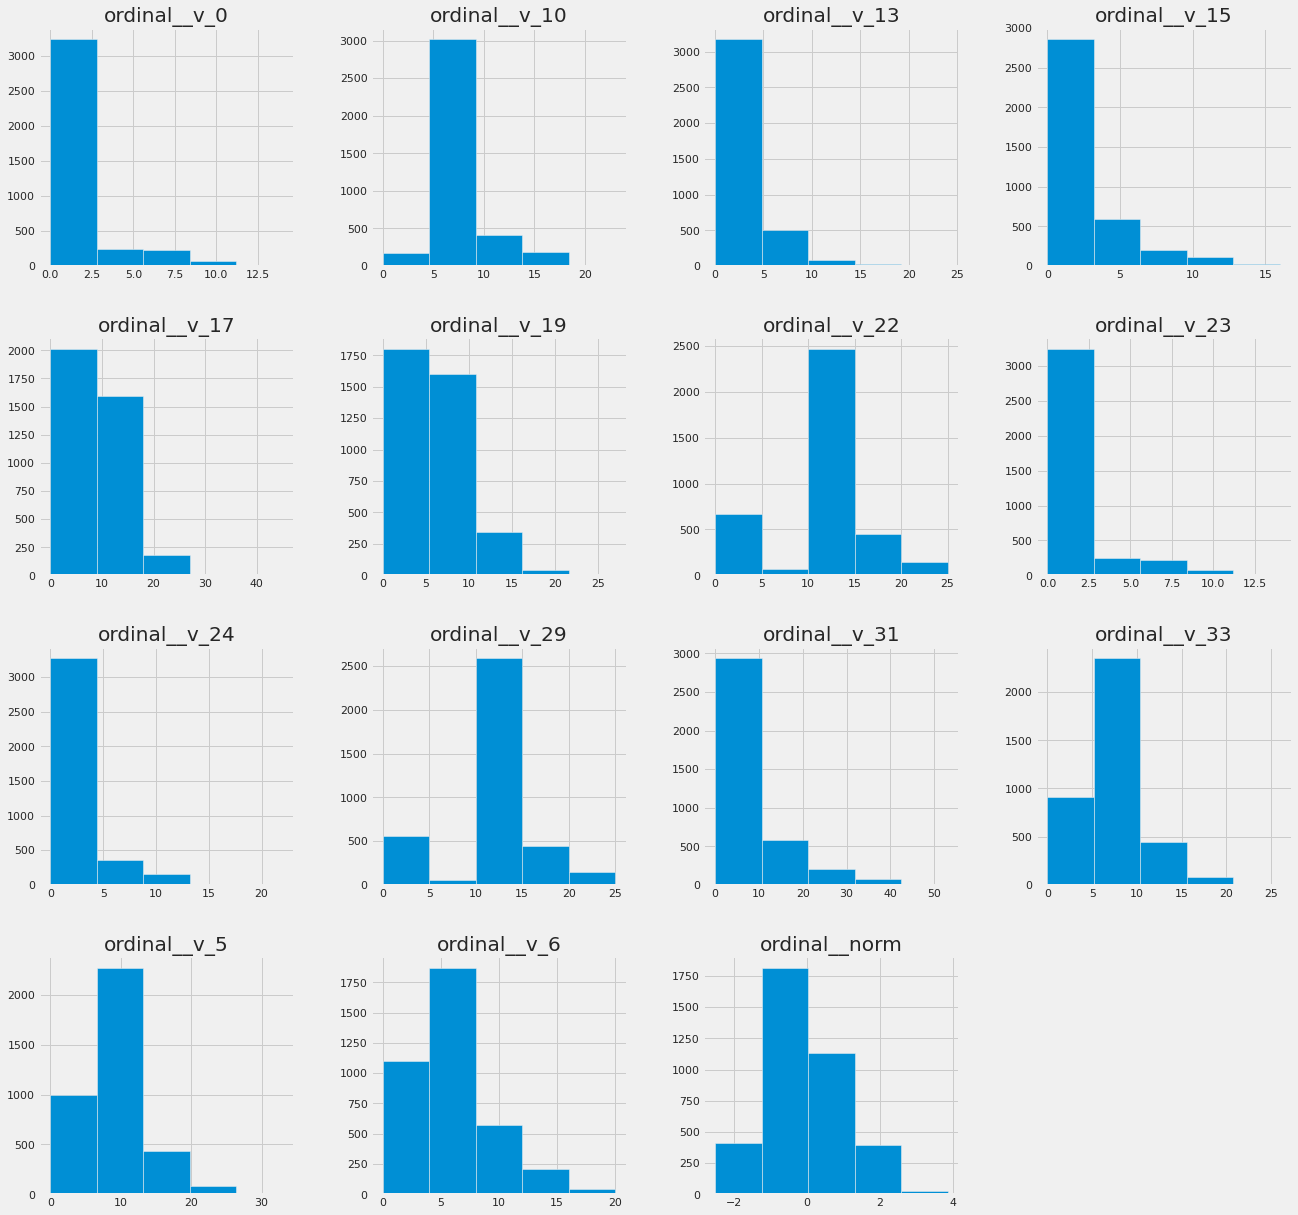

In [43]:
p = raw_data.hist(column=ordinal, layout=(4, 4), figsize=(20, 20), bins=5)
# pd.DataFrame.hist(column=)

## Base Non Parametric Estimate

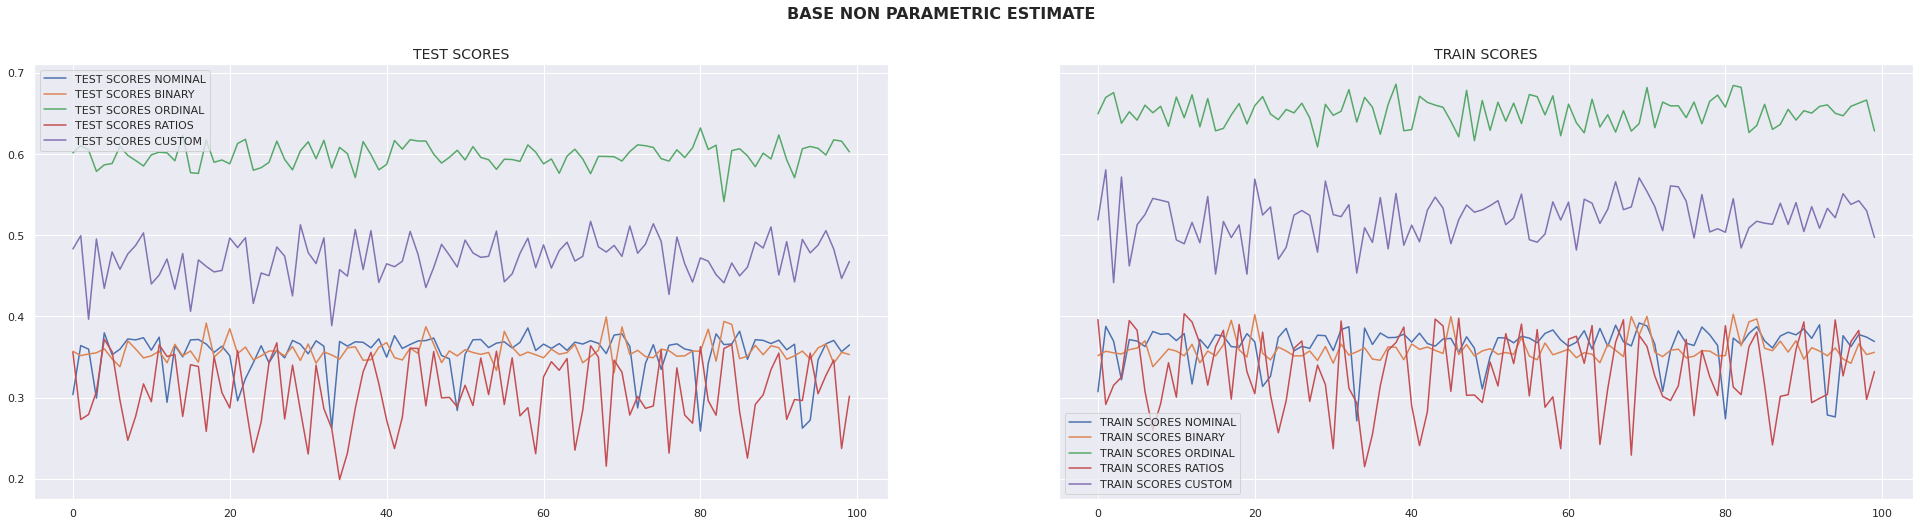

In [4]:
## cl_weight = sklearn.utils.compute_class_weight(class_weight='balanced',classes=[0,1,2],y=raw_data.target)
# cls_weight = {x:cl_weight[x] for x in range(3)}
N_JOBS = 24
# clf = De(class_weight='balanced',n_jobs=N_JOBS,max_depth=5)
# clf = DecisionTreeClassifier(random_state=42,max_depth=6)
REPEAT = 50
fig, ax = plt.subplots(1, 2, figsize=(30, 8), sharey=True)
with parallel_backend("loky", n_jobs=N_JOBS):

    # Nominal
    clf_nom = RandomForestClassifier(
        class_weight="balanced", n_jobs=N_JOBS, max_depth=3, random_state=42
    )
    clf_nom = DecisionTreeClassifier(random_state=42, max_depth=2)
    transformed_bin_scores = cross_validate(
        clf_nom,
        nominal_data,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=REPEAT, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=N_JOBS,
    )
    disp1 = ax[0].plot(
        transformed_bin_scores["test_score"], label="Test Scores NOMINAL".upper()
    )
    disp2 = ax[1].plot(
        transformed_bin_scores["train_score"], label="Train Scores NOMINAL".upper()
    )

    # Binary
    clf_bin = RandomForestClassifier(
        class_weight="balanced", n_jobs=N_JOBS, max_depth=3, random_state=42
    )
    clf_bin = DecisionTreeClassifier(random_state=42, max_depth=2)
    transformed_bin_scores = cross_validate(
        clf_bin,
        binary_data,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=REPEAT, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=N_JOBS,
    )
    disp1 = ax[0].plot(
        transformed_bin_scores["test_score"], label="Test Scores BINARY".upper()
    )
    disp2 = ax[1].plot(
        transformed_bin_scores["train_score"], label="Train Scores BINARY".upper()
    )

    # Ordinal
    clf_ord = RandomForestClassifier(
        class_weight="balanced", max_depth=5, random_state=42
    )
    clf_ord = DecisionTreeClassifier(
        class_weight="balanced", max_depth=5, random_state=42
    )
    transformed_bin_scores = cross_validate(
        clf_ord,
        ordinal_data,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=REPEAT, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=N_JOBS,
    )
    disp1 = ax[0].plot(
        transformed_bin_scores["test_score"], label="Test Scores Ordinal".upper()
    )
    disp2 = ax[1].plot(
        transformed_bin_scores["train_score"], label="Train Scores Ordinal".upper()
    )

    # Ratios
    clf_rio = RandomForestClassifier(
        class_weight="balanced", max_depth=2, random_state=42
    )
    clf_rio = DecisionTreeClassifier(
        class_weight="balanced", max_depth=2, random_state=42
    )
    transformed_bin_scores = cross_validate(
        clf_rio,
        ratios_data,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=REPEAT, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=N_JOBS,
    )
    #     fig, ax = plt.subplots(1,2,figsize=(30,8),sharey=True)
    disp1 = ax[0].plot(
        transformed_bin_scores["test_score"], label="Test Scores Ratios".upper()
    )
    disp2 = ax[1].plot(
        transformed_bin_scores["train_score"], label="Train Scores Ratios".upper()
    )

    # CUSTOM
    clf_cus = RandomForestClassifier(
        class_weight="balanced", n_jobs=N_JOBS, max_depth=5, random_state=42
    )
    clf_cus = DecisionTreeClassifier(
        class_weight="balanced", max_depth=5, random_state=42
    )
    custom_cols = ["binary__literal", "binary__sum", "ordinal__norm"]
    custom_data = raw_data.loc[:, custom_cols]
    transformed_bin_scores = cross_validate(
        clf_cus,
        custom_data,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=REPEAT, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=N_JOBS,
    )

    # Plotting
    disp1 = ax[0].plot(
        transformed_bin_scores["test_score"], label="Test Scores CUSTOM".upper()
    )
    disp2 = ax[1].plot(
        transformed_bin_scores["train_score"], label="Train Scores CUSTOM".upper()
    )
    ax[0].set_title("Test Scores".upper(), fontsize=14)
    ax[1].set_title("Train Scores".upper(), fontsize=14)
    s = ax[0].legend()
    s = ax[1].legend()
    disp = plt.suptitle(
        "Base Non Parametric Estimate".upper(), fontweight="heavy", fontsize=16
    )

In [5]:
clf_bin.fit(binary_data, raw_data.target)
clf_bin.get_depth()

2

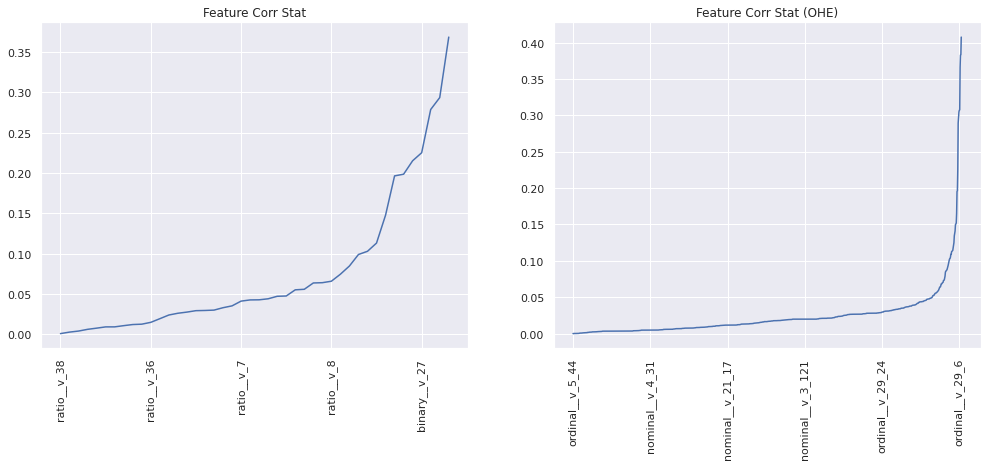

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
disp = (
    raw_data.corrwith(raw_data.target, method="pearson")
    .abs()
    .sort_values()
    .iloc[:-1]
    .plot(title="Feature Corr Stat", ax=ax[0], rot=90)
)
disp = (
    raw_data_ohe.corrwith(raw_data.target, method="pearson")
    .abs()
    .sort_values()
    .iloc[:-1]
    .plot(title="Feature Corr Stat (OHE)", ax=ax[1], rot=90)
)
# pd.DataFrame.plot

In [7]:
from prince import MCA, FAMD, MFA

X_combined = pd.concat(
    [raw_data_ohe.loc[:, raw_data_ohe_eval.columns], raw_data_ohe_eval],
    ignore_index=True,
    axis=0,
)
X_train_data = raw_data_ohe.loc[:, raw_data_ohe_eval.columns]


def optimal_components(mca, pca=None):
    mca_i = 0
    result = {}

    col_masses = mca.col_masses_.sort_values(ascending=False)
    for i in range(3, len(col_masses)):
        if col_masses.iloc[:i].sum() / col_masses.sum() > 0.99:
            print(i)
            mca_i = i
            break
    result[mca.__class__.__name__] = mca_i
    # 630

    # 510
    if type(pca) == sklearn.decomposition._pca.PCA:
        pca_i = 0
        d = pca.explained_variance_ratio_
        for i in range(3, len(d)):
            if d[:i].sum() / d.sum() > 0.99:
                print(i)
                pca_i = i
                break
        result[pca.__class__.__name__] = pca_i

    #     result = {}
    return result


# print(optimal_components(mca,pca=pca))
# print(optimal_components(mca_train,pca=pca_train))
def categorise(df):
    categorical_data = df.loc[:, ordinal + nominal]
    df.loc[:, ordinal + nominal] = categorical_data.astype("object")
    df.loc[:, binary] = df.loc[:, binary].astype(np.float64)
    return df


pca = PCA(svd_solver="full")
category_pca = pca.fit_transform(X_combined.loc[:, nominal_ohe + ordinal_ohe])

In [8]:
pca_i = 0
d = pca.explained_variance_ratio_
for i in range(3, len(d)):
    if d[:i].sum() / d.sum() > 0.99:
        print(i)
        pca_i = i
        break

551


In [9]:
len(ordinal_ohe)
ordinal_ohe

['ordinal__v_0_12',
 'ordinal__v_0_13',
 'ordinal__v_0_14',
 'ordinal__v_0_15',
 'ordinal__v_0_16',
 'ordinal__v_0_17',
 'ordinal__v_0_18',
 'ordinal__v_0_19',
 'ordinal__v_0_20',
 'ordinal__v_0_21',
 'ordinal__v_0_22',
 'ordinal__v_0_23',
 'ordinal__v_0_24',
 'ordinal__v_0_26',
 'ordinal__v_10_19',
 'ordinal__v_10_20',
 'ordinal__v_10_21',
 'ordinal__v_10_22',
 'ordinal__v_10_23',
 'ordinal__v_10_24',
 'ordinal__v_10_25',
 'ordinal__v_10_26',
 'ordinal__v_10_27',
 'ordinal__v_10_28',
 'ordinal__v_10_29',
 'ordinal__v_10_30',
 'ordinal__v_10_31',
 'ordinal__v_10_32',
 'ordinal__v_10_33',
 'ordinal__v_10_34',
 'ordinal__v_10_35',
 'ordinal__v_10_36',
 'ordinal__v_10_37',
 'ordinal__v_10_38',
 'ordinal__v_10_39',
 'ordinal__v_10_41',
 'ordinal__v_10_42',
 'ordinal__v_13_14',
 'ordinal__v_13_15',
 'ordinal__v_13_16',
 'ordinal__v_13_17',
 'ordinal__v_13_18',
 'ordinal__v_13_19',
 'ordinal__v_13_20',
 'ordinal__v_13_21',
 'ordinal__v_13_22',
 'ordinal__v_13_23',
 'ordinal__v_13_24',
 'ordi

In [10]:
len(ordinal + ["binary__literal", "ordinal__norm", "binary__sum"] + ratios)

29

In [11]:
raw_data_ohe.loc[
    :,
    ordinal
    + ["binary__literal", "ordinal__norm", "binary__sum"]
    + ratios
    + nominal_ohe
    + ordinal_ohe
    + binary,
]

,ordinal__v_0,ordinal__v_10,ordinal__v_13,ordinal__v_15,ordinal__v_17,ordinal__v_19,ordinal__v_22,ordinal__v_23,ordinal__v_24,ordinal__v_29,ordinal__v_31,ordinal__v_33,ordinal__v_5,ordinal__v_6,ordinal__norm,binary__literal,ordinal__norm,binary__sum,ratio__v_16,ratio__v_2,ratio__v_34,ratio__v_35,ratio__v_36,ratio__v_37,ratio__v_38,...,ordinal__v_6_14,ordinal__v_6_15,ordinal__v_6_16,ordinal__v_6_17,ordinal__v_6_18,ordinal__v_6_19,ordinal__v_6_20,ordinal__v_6_21,ordinal__v_6_22,ordinal__v_6_23,ordinal__v_6_24,ordinal__v_6_25,ordinal__v_6_26,ordinal__v_6_27,ordinal__v_6_28,binary__v_1,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_28,binary__v_30,binary__v_9,binary__sum,binary__literal
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.224387,0.000000,0.074796,0.261785,0.224387,0.560968,0.000000,0.000000,0.598366,0.037398,0.224387,0.224387,0.224387,-0.024106,0.784314,-0.024106,0.375,0.006668,-0.002532,0.008441,0.785015,0.396728,0.008441,0.405169,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0.375,0.784314
1,0.030471,0.213300,0.274242,0.091414,0.426599,0.274242,0.426599,0.030471,0.121886,0.365657,0.060943,0.213300,0.457071,0.152357,0.553182,0.701961,0.553182,0.625,0.076385,0.063361,0.070401,0.340270,0.434137,0.293336,0.621873,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0.625,0.701961
2,0.000000,0.253773,0.000000,0.042295,0.296068,0.253773,0.507546,0.000000,0.000000,0.549841,0.253773,0.253773,0.253773,0.169182,-0.195832,0.792157,-0.195832,0.500,0.029583,0.008787,0.014645,0.117158,0.497923,0.058579,0.629727,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0.500,0.792157
3,0.000000,0.308837,0.000000,0.154418,0.270232,0.270232,0.463255,0.000000,0.000000,0.501859,0.038605,0.270232,0.347441,0.270232,-0.031026,0.788235,-0.031026,0.500,0.020251,0.006015,0.070177,0.370935,0.401011,0.270682,0.431087,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0.500,0.788235
4,0.030975,0.201339,0.294264,0.139388,0.309752,0.356215,0.263289,0.061950,0.201339,0.356215,0.371702,0.278777,0.294264,0.294264,3.367909,0.576471,3.367909,0.500,0.204811,0.137523,0.261948,0.360178,0.409294,0.409294,0.392922,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0.500,0.576471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,0.000000,0.244542,0.000000,0.163028,0.285299,0.203785,0.489083,0.000000,0.000000,0.489083,0.081514,0.244542,0.489083,0.081514,-0.173594,0.792157,-0.173594,0.500,0.003201,0.026004,0.070012,0.770130,0.420071,0.380064,0.120020,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0.500,0.792157
3792,0.068626,0.366007,0.183004,0.251630,0.320256,0.205879,0.388883,0.000000,0.000000,0.411758,0.114377,0.251630,0.297381,0.366007,1.601241,0.733333,1.601241,0.750,0.028509,0.063938,0.097788,0.564159,0.135398,0.263274,0.473894,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,1,0.750,0.733333
3793,0.185197,0.324095,0.069449,0.115748,0.370394,0.162047,0.439843,0.115748,0.208347,0.439843,0.115748,0.208347,0.416693,0.069449,1.547941,0.733333,1.547941,0.750,0.032927,0.013133,0.112572,0.525335,0.121953,0.318953,0.112572,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0.750,0.733333


### WS1

Logistic Regression
****************************************
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       621
           1       0.78      0.71      0.74       932
           2       0.31      0.48      0.37       345

    accuracy                           0.63      1898
   macro avg       0.60      0.59      0.59      1898
weighted avg       0.67      0.63      0.64      1898



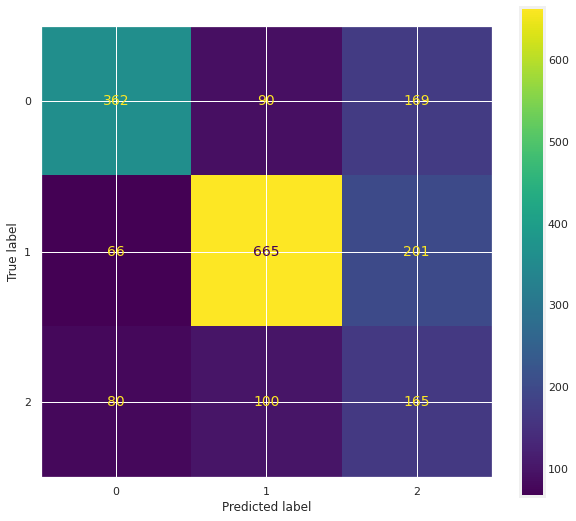

In [12]:
"""
PCA - For Data
"""
X = raw_data_ohe.loc[:, raw_data_ohe_eval.columns]
y = raw_data.target

cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
# cls_weight[2] = cls_weight[2]

kernel_pca = KernelPCA(kernel="linear", eigen_solver="dense", remove_zero_eig=True)
"""
ColumnTransformer
"""
trf = ColumnTransformer(
    [
        #     ('pca_binary',sklearn.kernel_approximation.RBFSampler(n_components=300,random_state=42),nominal_ohe+ordinal_ohe+binary),
        ("pca_binary", kernel_pca, nominal_ohe + ordinal_ohe + binary),
        # ('pca_discrete',kernel_pca,ordinal+['binary__literal','ordinal__norm','binary__sum']),
        (
            "stdscl",
            kernel_pca,
            ordinal + ["binary__literal", "ordinal__norm", "binary__sum"] + ratios,
        ),
    ],
    sparse_threshold=0,
    remainder="passthrough",
    n_jobs=-1,
)


"""
Model
"""

svc = SVC(
    probability=True,
    class_weight=CLASS_WEIGHTS,
    kernel="poly",
    degree=1,
    random_state=42,
    break_ties=False,
    tol=1e-08,
    gamma="auto",
    shrinking=True,
    C=200,
)

X = raw_data_ohe.loc[:, raw_data_ohe_eval.columns]
y = raw_data.target

cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
model = LogisticRegressionCV(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=False,
    multi_class="ovr",
    max_iter=10000,
    random_state=42,
    n_jobs=24,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=30),
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
)

"""
Final PipeLine
"""

clf_svc = Pipeline([("prep", trf), ("est", svc)], memory=CACHE_)
clf = Pipeline([("prep", trf), ("est", model)], memory=CACHE_)
# clf = make_imb_pipeline(trf,model)
with parallel_backend("loky", n_jobs=24):
    X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.5)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    fig1, ax1 = plt.subplots(1, 1, figsize=(9, 9))
    plt.style.use("fivethirtyeight")
    print("Logistic Regression")
    print("*" * 40)
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1)
    # transformed_bin_scores = cross_validate(clf,X,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2,random_state=30), scoring='f1_macro', return_train_score=True,n_jobs=-1)
    # disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores'.upper())
    #     print('\n\n')
    #     print("SVC")
    #     print("*"*40)
    #     fig2,ax2 = plt.subplots(1,1,figsize=(9,9))
    #     y_pred_svc = clf_svc.fit(X_train,y_train).predict(X_test)
    #     print(classification_report(y_test,y_pred_svc))
    #     disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_svc,ax=ax2)

TypeError: fit() missing 1 required positional argument: 'y'

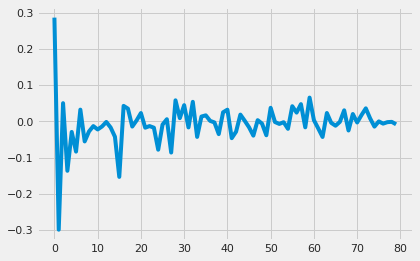

In [13]:
import copy

F = raw_data.loc[:, raw_data_eval.columns]
y = raw_data.target
K = 150
selector = SelectKBest(score_func=mutual_info_classif, k=150)
generator = make_union(
    PolynomialFeatures(degree=(2, 2), interaction_only=True, include_bias=False),
    SplineTransformer(extrapolation="continue", knots="quantile", n_knots=3, degree=2),
)
# f_uni = make_union(make_column_selector)
ct = make_column_transformer(
    (generator, ordinal + ratios + binary),
    remainder="drop",
    sparse_threshold=0,
    n_jobs=-1,
)
with parallel_backend("loky"):
    final_ = make_pipeline(
        PowerTransformer(),
        KernelPCA(n_components=80, kernel="linear", eigen_solver="arpack", n_jobs=-1),
    )
    new_features = make_pipeline(ct, selector, final_)
    F_new = new_features.fit_transform(F, y)
    F_enc = pd.DataFrame(F_new)


disp = F_enc.corrwith(raw_data.target).plot()
svc = SVC(
    probability=True,
    class_weight="balanced",
    kernel="poly",
    degree=1,
    random_state=42,
    break_ties=True,
    tol=1e-08,
    gamma="auto",
    shrinking=True,
    decision_function_shape="ovr",
    C=221.42857142857144,
    cache_size=1024,
    verbose=False,
)

model = LogisticRegressionCV(
    class_weight="balanced",
    fit_intercept=True,
    max_iter=10000,
    random_state=42,
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=30),
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
)
X_nom = raw_data_ohe.loc[:, nominal_ohe]
X_ord = raw_data_ohe.loc[:, ordinal_ohe]

enc = make_pipeline(BernoulliRBM(random_state=42), SelectKBest(50))
X_t = enc.fit_transform(X_nom)

model = LogisticRegressionCV(
    class_weight="balanced",
    fit_intercept=True,
    max_iter=10000,
    random_state=42,
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=30),
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
)
# clf = make_pipeline(StandardScaler(),KernelPCA(n_components=120,kernel='linear',eigen_solver='arpack',n_jobs=-1),model)
with parallel_backend("loky", n_jobs=24):

    scores1 = cross_validate(
        model,
        X_t,
        y,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
        n_jobs=-1,
        scoring="f1_macro",
        return_train_score=True,
    )
    scores2 = cross_validate(
        svc,
        X_t,
        y,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
        n_jobs=-1,
        scoring="f1_macro",
        return_train_score=True,
    )

scores1, scores2

### RBM

In [ ]:
brbm_nom_ = BernoulliRBM(
    n_components=220, random_state=42, learning_rate=0.1, batch_size=5, n_iter=5
)
brbm_ord_ = BernoulliRBM(
    n_components=160, random_state=42, learning_rate=0.1, batch_size=5, n_iter=5
)
brbm_bin_ = BernoulliRBM(
    n_components=7, random_state=42, batch_size=5, n_iter=5, learning_rate=0.1
)
selector = SelectPercentile(score_func=mutual_info_classif, percentile=50)
brbm_nom = make_pipeline(brbm_nom_, selector, memory=CACHE_)
brbm_ord = make_pipeline(brbm_ord_, selector, memory=CACHE_)
brbm_bin = make_pipeline(brbm_bin_, selector, memory=CACHE_)
cts = make_column_transformer(
    (brbm_nom, nominal_ohe),
    (brbm_ord, ordinal_ohe),
    (brbm_bin, binary),
    remainder="drop",
    n_jobs=24,
    sparse_threshold=0,
)
enc = Pipeline(
    [
        ("rbm", cts),
        ("feature_importances", SelectKBest(score_func=mutual_info_classif, k="all")),
    ],
    memory=CACHE_,
)
cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
cv_ = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=30)
ls_ = np.linspace(1e-04, 0.5, num=10)
model = LogisticRegressionCV(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=False,
    max_iter=10000,
    random_state=42,
    n_jobs=-1,
    cv=cv_,
    scoring="f1_macro",
    solver="saga",
    Cs=100,
)
clf = make_pipeline(cts, model, memory=CACHE_)
with parallel_backend("loky", n_jobs=24):
    X = raw_data_ohe
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.25)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    fig1, ax1 = plt.subplots(1, 1, figsize=(9, 9))
    plt.style.use("fivethirtyeight")
    print("Logistic Regression")
    print("*" * 40)
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1)
    #     scores = cross_validate(clf,raw_data_ohe,raw_data.target,cv=cv_,n_jobs=24,scoring='f1_macro',return_train_score=True)
#     with parallel_backend('loky',n_jobs=24):
# fig, ax = plt.subplots(1,1,figsize=(30,6))
# disp1 = ax.plot(scores['test_score'],label='Test Scores OHE(RBM)'.upper())
# disp2 = ax.plot(scores['train_score'],label='Train Scores OHE(RBM)'.upper())
# ax.legend()
# enc = make_pipeline(,SelectKBest(50))
# X_t = enc.fit_transform(X_nom,)
# enc.get_params()
# with parallel_backend('loky',n_jobs=24):
#     X_t = enc.fit_transform(raw_data_ohe,raw_data.target)

In [ ]:
with parallel_backend("loky", n_jobs=24):
    #     X_train_enc = cts.fit_transform(X_train,y_train)
    #     X_test_enc = cts.transform(X_test)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)

    fig1, ax1 = plt.subplots(1, 1, figsize=(9, 9))
    plt.style.use("fivethirtyeight")
    print("Logistic Regression")
    print("*" * 40)
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1)

In [ ]:
import widen_notebook
from importlib import reload

reload(widen_notebook)

In [ ]:
mic = mutual_info_classif(X_t, raw_data.target)
plt.plot(mic)

In [ ]:
import copy

F = raw_data.loc[:, ordinal + ratios + binary]
y = raw_data.target
K = 50
transformer = make_union(
    PolynomialFeatures(degree=3, interaction_only=True, include_bias=False),
    SplineTransformer(extrapolation="continue", knots="quantile", n_knots=3, degree=2),
)
# f_uni = make_union(make_column_selector)
F_enc = pd.DataFrame(
    transformer.fit_transform(F), columns=transformer.get_feature_names_out()
)
F_enc.loc[:, ordinal] = raw_data.loc[:, ordinal + ratios + binary]
chi, p = chi2(F_enc, raw_data.target)

selector_1 = SelectKBest(score_func=chi2, k=K)
selector_1.fit(F_enc, y)
fs1 = selector_1.get_feature_names_out()

selector_2 = SelectKBest(score_func=mutual_info_classif, k=K)
selector_2.fit(F_enc, y)
fs2 = selector_2.get_feature_names_out()

selector_3 = SelectKBest(score_func=f_classif, k=K)
selector_3.fit(F_enc, y)
fs3 = selector_3.get_feature_names_out()

all_f = list(fs1) + list(fs2) + list(fs3)
perf_ = dict(
    Counter(
        all_f,
    )
)
perf = copy.deepcopy(perf_)
for k in perf_:
    if perf_[k] != 3:
        del perf[k]
perf

In [ ]:
kap = sklearn.kernel_approximation.RBFSampler(
    n_components=len(nominal_ohe + ordinal_ohe + binary) - 1, random_state=42, gamma=10
)
kap.fit_transform(raw_data_ohe.loc[:, nominal_ohe + ordinal_ohe + binary])

In [ ]:
from sklearn.mixture import *

X = raw_data.loc[:, raw_data_eval.columns]
y = raw_data.target
kernel = RBFSampler(random_state=42, n_components=len(nominal + ordinal))
# Try GMMs using different types of covariances.
n_classes = 3
estimators = {
    cov_type: BayesianGaussianMixture(
        n_components=n_classes,
        covariance_type=cov_type,
        n_init=20,
        max_iter=100,
        random_state=42,
        init_params="kmeans",
        tol=0.001,
    )
    for cov_type in ["spherical", "full"]
}
ct = make_column_transformer(
    (kernel, nominal_ohe + ordinal_ohe),
    (
        PCA(svd_solver="full"),
        binary + ordinal + ratios + ["binary__literal", "ordinal__norm", "binary__sum"],
    ),
    remainder="passthrough",
    sparse_threshold=0,
    n_jobs=-1,
)
X_ = {}
preds_ = {}

for k, estimator in estimators.items():
    # ct = make_column_transformer(('passthrough',X.col))
    # estimator.means_init = np.array(
    #     [X.loc[:,nominal_ohe+ordinal_ohe][y == i].mean(axis=0) for i in range(n_classes)]
    # )
    with parallel_backend("threading", n_jobs=24):
        estimator.means_init = np.array(
            [X[y == i].mean(axis=0) for i in range(n_classes)]
        )

        trf = make_pipeline(estimator)
        X_[k] = trf.fit(X)
    preds_[k] = trf.predict_proba(X)
    ConfusionMatrixDisplay.from_predictions(y, trf.predict(X))
    print(classification_report(y, trf.predict(X)))

In [ ]:
# for k,p in preds_:
#     pr = pd.DataFrame()
preds_

In [ ]:
# kernel = sklearn.gaussian_process.kernels.PairwiseKernel(metric='additive_chi2')
# ct = make_column_transformer((kernel,nominal+ordinal),(PCA(svd_solver='full'),binary+ratios+['binary__literal','ordinal__norm','binary__sum']),remainder='passthrough',sparse_threshold=0,n_jobs=-1)
from sklearn.mixture import *

X = raw_data_ohe.loc[:, raw_data_ohe_eval.columns]
y = raw_data.target
# X_t = ct.fit_transform(X)
# kernel(X,y.to_numpy().reshape(-1,1))
kernel = RBFSampler(random_state=42, n_components=len(nominal_ohe + ordinal_ohe))
# Try GMMs using different types of covariances.
n_classes = 3
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, n_init=10, random_state=42
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}
ct = make_column_transformer(
    (kernel, nominal_ohe + ordinal_ohe),
    (
        PCA(svd_solver="full"),
        binary + ordinal + ratios + ["binary__literal", "ordinal__norm", "binary__sum"],
    ),
    remainder="passthrough",
    sparse_threshold=0,
    n_jobs=-1,
)
X_ = {}
for k, estimator in estimators.items():
    ct = make_column_transformer(("passthrough", nominal_ohe + ordinal_ohe))
    trf = make_pipeline(ct, estimator)
    X_[k] = trf.fit(X)

In [ ]:
lf = clf[-1]
lf.C_

In [ ]:
y_ovr = LabelBinarizer().fit_transform(y)
y_df = pd.DataFrame(y_ovr, index=raw_data.index, columns=["0", "1", "2"])

In [ ]:
X_transformed = trf.fit_transform(X)
from tqdm import trange

# mics = []
y_ovr = LabelBinarizer().fit_transform(y)
y_df = pd.DataFrame(y_ovr, index=raw_data.index, columns=["0", "1", "2"])

mics = pd.DataFrame(index=X.columns)
mics_transformed = pd.DataFrame(index=np.arange(X_transformed.shape[1]))

# for i in range(3,10):
def get_info_mic(idx, X=X, y=y_df["1"]):
    global mics, mics_transformed
    mic = mutual_info_classif(X, y, random_state=42, n_neighbors=idx)
    mics[f"k__{idx}"] = mic
    mic = mutual_info_classif(X_transformed, y, random_state=42, n_neighbors=idx)
    mics_transformed[f"k__{idx}"] = mic


with parallel_backend("threading", n_jobs=-1):
    Parallel()(delayed(get_info_mic)(i) for i in range(3, 10))

mics["mean"] = mics.loc[
    :,
    [
        "k__3",
        "k__4",
        "k__5",
        "k__6",
        "k__7",
        "k__8",
        "k__9",
    ],
].mean(axis=1)
mics_transformed["mean"] = mics_transformed.loc[
    :,
    [
        "k__3",
        "k__4",
        "k__5",
        "k__6",
        "k__7",
        "k__8",
        "k__9",
    ],
].mean(axis=1)
# mics_transformed['mean'] = mics_transformed.mean(axis=1)
mics.sort_values(by="mean", ascending=False, inplace=True)
mics_transformed.sort_values(by="mean", ascending=False, inplace=True)

import copy


def mic_result_analyze(df):
    valid_mic = df[df["mean"] > 0].index
    all_f = df.index
    invalid_mic = all_f.difference(valid_mic)
    print("valid fs", len(valid_mic))
    counts = {"ordinal": 0, "nominal": 0, "binary": 0, "ratio": 0}
    detailed_counts = {x: 0 for x in ordinal + nominal + binary + ratios}

    for i in invalid_mic:
        for k in counts:
            if k in i:
                counts[k] += 1

    for i in invalid_mic:
        for k in detailed_counts:
            if k in i:
                detailed_counts[k] += 1
    detailed_counts1 = copy.deepcopy(detailed_counts)
    for k in detailed_counts:
        if detailed_counts[k] > 0:
            #             print(f'{k}:  {detailed_counts[k]}')
            pass
        else:
            del detailed_counts1[k]
    return counts, detailed_counts1, valid_mic


def mic_info(mics, mics_transformed):
    valid_mic_tr = len(mics_transformed[mics_transformed["mean"] > 0.003].index)
    print(f"valid fs after transformation: {valid_mic_tr}")
    # print(f'max mic {mics['mean'].max()}')
    print(mics["mean"].idxmax(), mics["mean"].max())
    print(mics_transformed["mean"].idxmax(), mics_transformed["mean"].max())


counts, detailed_counts, valid = mic_result_analyze(mics)
mic_info(mics, mics_transformed)

In [ ]:
mics_db

In [ ]:
mics_db["1"] = [counts, detailed_counts, valid]

In [ ]:
import shelve

with shelve.open("../data/mic_stats.shelf") as stats_db:
    stats_db["mic"] = mics_db

In [ ]:
X = raw_data.loc[:, high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.2)
model = SVC(
    probability=True,
    class_weight="balanced",
    kernel="linear",
    random_state=42,
    break_ties=True,
    tol=0.0001,
    gamma="auto",
    shrinking=False,
    decision_function_shape="ovr",
    C=125.71428571428572,
)
model = SVC(
    probability=True,
    class_weight="balanced",
    kernel="linear",
    random_state=42,
    break_ties=False,
    tol=1e-08,
    gamma="auto",
    shrinking=False,
    decision_function_shape="ovo",
    C=221.42857142857144,
)

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

with parallel_backend("loky"):
    X_train_enc = trf.fit_transform(X_train, y_train)
    X_test_enc = trf.transform(X_test)
    # fit_transform
    clf = Pipeline(
        [("prep", trf), ("svc", model)], memory=Memory(DATA_SAVE_PATH, verbose=0)
    )
    param_distributions = {
        "svc__tol": [10 ** (-x) for x in range(3, 9)],
        "svc__C": np.linspace(150, 250, num=50),
    }
    model_search = HalvingRandomSearchCV(
        clf,
        param_distributions=param_distributions,
        scoring="f1_macro",
        random_state=42,
        return_train_score=True,
        n_jobs=-1,
        verbose=1,
        factor=2,
        cv=RepeatedStratifiedKFold(n_splits=2),
    )
    # model_search.fit(X,y)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    report_model(y_test, y_pred)

In [ ]:
mca_comp = MCA(
    n_components=610, benzecri=False, random_state=42, n_iter=20
).fit_transform(
    pd.get_dummies(raw_data.loc[:, nominal + ordinal], columns=nominal + ordinal)
)
X = pd.concat(
    [
        raw_data.loc[
            :, binary + ratios + ["binary__literal", "ordinal__norm", "binary__sum"]
        ],
        mca_comp,
    ],
    axis=1,
    ignore_index=True,
)
with parallel_backend("loky"):
    clf = LogisticRegressionCV(
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
        cv=StratifiedKFold(n_splits=3),
        multi_class="ovr",
        max_iter=10000,
    )
    transformed_bin_scores = cross_validate(
        clf,
        X,
        raw_data.target,
        cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=30),
        scoring="f1_macro",
        return_train_score=True,
        n_jobs=24,
    )
    disp = plt.plot(
        transformed_bin_scores["test_score"], label="Test Scores NOMINAL".upper()
    )

#### COV estimation

In [ ]:
# X= raw_data.drop(['target'],axis=1)
X_raw = raw_data.loc[
    :,
    nominal
    + ordinal
    + binary
    + ["binary__literal", "ordinal__norm", "binary__sum"]
    + ratios,
]
X = pd.concat(
    [raw_data.loc[:, raw_data_eval.columns], raw_data_eval], ignore_index=True, axis=0
)
from joblib import Parallel

X_eval = raw_data_eval
cov_estimators = [
    EmpiricalCovariance(),
    MinCovDet(),
    MinCovDet(),
    OAS(),
    LedoitWolf(),
    ShrunkCovariance(),
]
with parallel_backend("threading", n_jobs=-1):
    fitted_cov_estimators = [x.fit(X) for x in cov_estimators]


cov_scores_eval = [x.score(X_eval) for x in fitted_cov_estimators]
cov_matrices = [
    pd.DataFrame(
        est.covariance_, columns=est.feature_names_in_, index=est.feature_names_in_
    )
    for est in cov_estimators
]


import copy

T = 0.7
pos_variable_f = [{c: [] for c in X.columns} for _ in range(len(cov_matrices))]
neg_variable_f = [{c: [] for c in X.columns} for _ in range(len(cov_matrices))]
for idx, C in enumerate(cov_matrices):
    cols = list(C.columns)
    for f in cols:
        # not_same_f = cols.remove('f')
        not_same_f = copy.deepcopy(cols)
        not_same_f.remove(f)
        cov_f = C[f].loc[not_same_f]
        pos_imp_co_f = cov_f[cov_f > T]
        neg_imp_co_f = cov_f[cov_f < -T]
        pos_variable_f[idx][f].extend(list(pos_imp_co_f.index))
        neg_variable_f[idx][f].extend(list(neg_imp_co_f.index))
pos_variable_f = [
    {prel_key: prel[prel_key] for prel_key in prel if len(prel[prel_key]) != 0}
    for prel in pos_variable_f
]
neg_variable_f = [
    {nrel_key: nrel[nrel_key] for nrel_key in nrel if len(nrel[nrel_key]) != 0}
    for nrel in neg_variable_f
]


prel_coll = [set() for _ in range(len(cov_matrices))]
nrel_coll = [set() for _ in range(len(cov_matrices))]
for idx, rel in enumerate(pos_variable_f):
    for features in rel.values():
        for f in features:
            prel_coll[idx].add(f)
    for feature in rel.keys():
        # for f in features:
        prel_coll[idx].add(feature)
for idx, rel in enumerate(neg_variable_f):
    for features in rel.values():
        for f in features:
            nrel_coll[idx].add(f)
    for feature in rel.keys():
        # for f in features:
        nrel_coll[idx].add(feature)

nrel_coll = [list(L) for L in nrel_coll]
prel_coll = [list(L) for L in prel_coll]
high_variable_f = [
    list(set(prel_coll[idx] + nrel_coll[idx])) for idx in range(len(cov_matrices))
]
total_feature_set = set(raw_data.drop(["target"], axis=1).columns)
low_variable_f = [list(total_feature_set - set(high_f)) for high_f in high_variable_f]

In [ ]:
[len(f) for f in high_variable_f]

In [ ]:
master_scores_nrel = []
FOLDS = dict(n_splits=2, n_repeats=5)
with parallel_backend("loky"):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:, nrel_coll[idx]]
        y = raw_data.target
        model = DecisionTreeClassifier(
            random_state=42, class_weight="balanced", max_depth=5
        )
        clf = OneVsOneClassifier(model, n_jobs=-1)
        scores = cross_validate(
            clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(**FOLDS),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        master_scores_nrel.append(
            {
                "test_score": scores["test_score"].mean(),
                "train_score": scores["train_score"].mean(),
            }
        )
master_scores_nrel

In [ ]:
master_scores_prel = []
with parallel_backend("loky"):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:, prel_coll[idx]]
        y = raw_data.target
        model = DecisionTreeClassifier(
            random_state=42, class_weight="balanced", max_depth=5
        )
        clf = OneVsRestClassifier(model, n_jobs=-1)
        scores = cross_validate(
            clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(**FOLDS),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        master_scores_prel.append(
            {
                "test_score": scores["test_score"].mean(),
                "train_score": scores["train_score"].mean(),
            }
        )

master_scores_prel

In [ ]:
from tqdm import trange, tqdm

master_scores = []
with parallel_backend("loky"):
    for idx in trange(len(prel_coll)):
        X = raw_data.loc[:, high_variable_f[idx]]
        y = raw_data.target
        mask = gen_categorical_mask(X)

        # model = HistGradientBoostingClassifier(random_state=42,categorical_features=mask,min_samples_leaf=3,max_leaf_nodes=3,max_iter=100, learning_rate=0.12)
        # clf = OneVsOneClassifier(model,n_jobs=-1)
        model = HistGradientBoostingClassifier(
            random_state=42,
            categorical_features=mask,
        )
        # model = DecisionTreeClassifier(random_state=42, class_weight='balanced',max_depth=5)
        # clf = OneVsRestClassifier(model,n_jobs=-1)
        model = LogisticRegressionCV(
            class_weight="balanced",
            fit_intercept=False,
            multi_class="ovr",
            max_iter=10000,
            random_state=42,
            l1_ratios=np.linspace(0.0, 1.0, num=5),
            penalty="elasticnet",
            solver="saga",
        )
        # model = LogisticRegressionCV(class_weight='balanced',fit_intercept=False,multi_class='ovr',max_iter=10000,random_state=42,penalty='elasticnet',solver='saga',cv=StratifiedKFold(n_splits=2),n_jobs=-1,l1_ratios=np.linspace(0.0,1.0,num=5))
        model = LogisticRegressionCV(
            class_weight="balanced",
            fit_intercept=False,
            multi_class="ovr",
            max_iter=100000,
            random_state=42,
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=2),
            scoring="f1_macro",
            solver="lbfgs",
            Cs=10,
        )
        LG_clf = model
        scores = cross_validate(
            LG_clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
            return_estimator=True,
        )
        master_scores.append(
            {
                "test_score": scores["test_score"].mean(),
                "train_score": scores["train_score"].mean(),
            }
        )

master_scores

In [ ]:
sfs_estimator = LogisticRegression(
    class_weight="balanced",
    multi_class="ovr",
    solver="lbfgs",
    max_iter=10000,
    fit_intercept=False,
    random_state=42,
    n_jobs=-1,
    tol=0.000001,
)
sfs = SequentialFeatureSelector(
    estimator=sfs_estimator,
    n_features_to_select="auto",
    tol=0.001,
    scoring="f1_macro",
    n_jobs=-1,
    direction="backward",
    cv=StratifiedKFold(n_splits=2),
)
rfecv = RFECV(
    sfs_estimator,
    cv=StratifiedKFold(n_splits=2),
    scoring="f1_macro",
    n_jobs=-1,
)

In [ ]:
"""
Training Set Generation
"""
X = raw_data.loc[:, high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.2)
# X_train, X_valid, y_train, y_valid = gen_train_test(X_train,y_train, 0.5)

"""
Column Selectors
"""
ordinal_cols = make_column_selector(pattern="ordinal__*")
nominal_cols = make_column_selector(pattern="nominal__*")
binary_cols = make_column_selector(pattern="binary__*")
kpca_cols = make_column_selector(pattern="binary__*|nominal__*|ordinal__*|bin_*|ord_*")


"""
Prep
"""
nominal_master = pd.concat([nominal_data, nominal_data_eval], axis=0)
ordinal_master = pd.concat([ordinal_data, ordinal_data_eval], axis=0)


def nominal_categories(X):
    ct = make_column_transformer(
        (OneHotEncoder(sparse=False), nominal), sparse_threshold=0, remainder="drop"
    )
    ct.fit(nominal_master.astype("int"))
    results = ct.named_transformers_["onehotencoder"].categories_
    category_db = {x: Categs for x, Categs in zip(nominal, results)}
    tmp = make_column_transformer(
        ("passthrough", nominal_cols), sparse_threshold=0, remainder="drop"
    )
    tmp.fit(X.astype("int"))
    selected_features = [
        x.replace("passthrough__", "") for x in tmp.get_feature_names_out()
    ]
    unique_categories_nom = [category_db[f] for f in selected_features]
    return unique_categories_nom


def ordinal_categories(X):
    ct = make_column_transformer(
        (OneHotEncoder(sparse=False), ordinal), sparse_threshold=0, remainder="drop"
    )
    ct.fit(ordinal_master)
    results = ct.named_transformers_["onehotencoder"].categories_
    category_db = {x: Categs for x, Categs in zip(ordinal, results)}
    tmp = make_column_transformer(
        ("passthrough", ordinal_cols), sparse_threshold=0, remainder="drop"
    )
    tmp.fit(X)
    selected_features = [
        x.replace("passthrough__", "") for x in tmp.get_feature_names_out()
    ]
    unique_categories_ord = [category_db[f] for f in selected_features]
    return unique_categories_ord


def nominal_value_counts():
    df = nominal_master.astype("int")
    df_c = {}
    for c in df.columns:
        df_c[c] = df[c].value_counts()
    return df_c


def ordinal_value_counts():
    df = ordinal_master
    df_c = {}
    for c in df.columns:
        df_c[c] = df[c].value_counts()
    return df_c


"""
MCA - For Categorical Data
"""
kernel_pca = make_pipeline(
    KernelPCA(
        kernel="cosine",
        random_state=42,
        eigen_solver="dense",
        n_jobs=-1,
        fit_inverse_transform=False,
    )
)

"""
Samplers
"""
sampler_estimator = DecisionTreeClassifier(random_state=10, class_weight="balanced")
under_sampler = InstanceHardnessThreshold(
    random_state=42, estimator=sampler_estimator, cv=5, n_jobs=-1
)
over_sampler_sampler = RandomOverSampler(random_state=42)


"""
ColumnTransformer
"""
trf = ColumnTransformer(
    [
        ("kernel_pca", kernel_pca, kpca_cols),
        (
            "stdscl",
            make_pipeline(StandardScaler(), kernel_pca),
            make_column_selector(pattern="ratio__*"),
        ),
    ],
    sparse_threshold=0,
    remainder="passthrough",
    n_jobs=-1,
)


"""
Model
"""
model = LogisticRegressionCV(
    class_weight="balanced",
    fit_intercept=True,
    multi_class="ovr",
    max_iter=10000,
    random_state=42,
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=5),
    scoring="f1_macro",
    solver="lbfgs",
    Cs=100,
)


"""
Final PipeLine
"""
# clf = make_imb_pipeline(under_sampler,over_sampler,trf,model,memory=Memory(DATA_SAVE_PATH,verbose=0))
clf = make_imb_pipeline(
    trf, OneVsOneClassifier(model, n_jobs=-1), memory=Memory(DATA_SAVE_PATH, verbose=0)
)


"""
Execution
"""


def execute():
    with parallel_backend("loky"):

        print("Started Fitting Transformer")
        with parallel_backend("loky"):
            X_train_enc = trf.fit_transform(X_train, y_train)
            X_test_enc = trf.transform(X_test)
            # X_train_enc

            X_train_df = pd.DataFrame(
                X_train_enc, columns=trf.get_feature_names_out(), index=X_train.index
            )
            X_test_df = pd.DataFrame(
                X_test_enc, columns=trf.get_feature_names_out(), index=X_test.index
            )

            X_train_df.corrwith(raw_data.target.loc[X_train.index]).sort_values(
                ascending=False
            ).plot()
            X_test_df.corrwith(raw_data.target.loc[X_test.index]).sort_values(
                ascending=False
            ).plot()
            disp = plt.legend()

        print("Started training classifier")
        y_pred = clf.fit(X_train, y_train).predict(X_test)
    return y_pred


"""
Plotting
"""


def report_model(y_test, y_pred):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.style.use("fivethirtyeight")
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
    # scores = cr(clf,X,y,cv=RepeatedStratifiedKFold(**FOLDS),n_jobs=-1,scoring='f1_macro',return_train_score=True)

    print(classification_report(y_test, y_pred))


y_pred = execute()
report_model(y_test, y_pred)

In [ ]:
X = raw_data.loc[:, high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.2)
model = SVC(
    probability=True,
    class_weight="balanced",
    kernel="linear",
    random_state=42,
    break_ties=True,
    tol=0.0001,
    gamma="auto",
    shrinking=False,
    decision_function_shape="ovr",
    C=125.71428571428572,
)
model = SVC(
    probability=True,
    class_weight="balanced",
    kernel="linear",
    random_state=42,
    break_ties=False,
    tol=1e-08,
    gamma="auto",
    shrinking=False,
    decision_function_shape="ovo",
    C=221.42857142857144,
)

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV

with parallel_backend("loky"):
    X_train_enc = trf.fit_transform(X_train, y_train)
    X_test_enc = trf.transform(X_test)
    # fit_transform
    clf = Pipeline(
        [("prep", trf), ("svc", model)], memory=Memory(DATA_SAVE_PATH, verbose=0)
    )
    param_distributions = {
        "svc__tol": [10 ** (-x) for x in range(3, 9)],
        "svc__C": np.linspace(150, 250, num=50),
    }
    model_search = HalvingRandomSearchCV(
        clf,
        param_distributions=param_distributions,
        scoring="f1_macro",
        random_state=42,
        return_train_score=True,
        n_jobs=-1,
        verbose=1,
        factor=2,
        cv=RepeatedStratifiedKFold(n_splits=2),
    )
    # model_search.fit(X,y)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    report_model(y_test, y_pred)

In [ ]:
# best_clfs = [best_clf_lgcv,best_clf_svc]
import shelve

with shelve.open("../models/best_clfs.db") as mdb:
    # best_clf_lgcv = mdb['LogisticRegressionCV_KernelPCA.model']
    # best_clf_svc = mdb['SVC_Linear_KernelPCA.model']
    clf_ovo_lgcv = mdb["OVO_LogisticRegressionCV_KernelPCA.model"]

In [ ]:
with open("../models/clf_hist_ord_nom_cat", "rb") as fp:
    tm_clf = pickle.load(fp)
clf_hist = Pipeline(
    [("prep", trf), ("hist", tm_clf[1])], memory=Memory(DATA_SAVE_PATH, verbose=0)
)
y_pred = tm_clf.fit(X_train, y_train).predict(X_test)
report_model(y_test, y_pred)

In [ ]:
# model.decision_function(X)
X = raw_data.loc[:, high_variable_f[3]]
X_eval = raw_data_eval.loc[:, high_variable_f[3]]
y = raw_data.target
model = LogisticRegressionCV(
    class_weight="balanced",
    fit_intercept=False,
    multi_class="ovr",
    max_iter=100000,
    random_state=42,
    n_jobs=-1,
    cv=RepeatedStratifiedKFold(n_splits=5, random_state=42),
    scoring="f1_macro",
    solver="liblinear",
    Cs=100,
)
clf = make_pipeline(trf, OneVsOneClassifier(model, n_jobs=-1), memory=CACHE_)
with parallel_backend("loky"):
    clf.fit(X, y)

X_train, X_test, y_train, y_test = gen_train_test(X, y, 0.5)
y_pred = clf.fit(X_train, y_train).predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
)
print(classification_report(y_test, y_pred))
# prob = clf.predict_proba(X_eval)
# LG_eval_prob: pd.DataFrame = pd.DataFrame(prob,columns=['Class '+str(i) for i in range(3)],index=raw_data_eval.index)
# LG_eval_prob.sort_values(by='Class 2',ascending=False, inplace=True)
# LG_eval_prob[LG_eval_prob['Class 2']>0.9].index

In [ ]:
# low_variable_f = []
# total_feature_set = set(raw_data.drop(['target'],axis=1).columns)
# low_variable_f = [list(total_feature_set-set(high_f)) for high_f in high_variable_f]
low_var_master_scores = []
# FOLDS=()
with parallel_backend("loky"):
    for idx in range(len(prel_coll)):
        X = raw_data.loc[:, low_variable_f[idx]]
        y = raw_data.target
        # mask = gen_categorical_mask(X)
        # model = HistGradientBoostingClassifier(random_state=42,categorical_features=mask,min_samples_leaf=3,max_leaf_nodes=3,max_iter=100, learning_rate=0.12)
        # clf = OneVsOneClassifier(model,n_jobs=-1)
        model = BalancedRandomForestClassifier(
            random_state=42, class_weight="balanced", max_depth=5
        )
        clf = model
        # clf = model
        scores = cross_validate(
            clf,
            X,
            y,
            cv=RepeatedStratifiedKFold(),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        low_var_master_scores.append(
            {
                "test_score": scores["test_score"].mean(),
                "train_score": scores["train_score"].mean(),
            }
        )

low_var_master_scores

In [ ]:
low_var_f = low_variable_f[3]
high_var_f = high_variable_f[3]
all_f = list(raw_data_eval.columns)
X_low = raw_data.loc[:, low_var_f]
X_high = raw_data.loc[:, high_var_f]
X_all = raw_data.loc[:, all_f]
y = raw_data.target


nominal_master = pd.concat([nominal_data, nominal_data_eval], axis=0)
ordinal_master = pd.concat([ordinal_data, ordinal_data_eval], axis=0)
ordinal_cols = make_column_selector(pattern="ordinal__*")
nominal_cols = make_column_selector(pattern="nominal__*")


def nominal_categories(X):
    ct = make_column_transformer(
        (OneHotEncoder(sparse=False), nominal), sparse_threshold=0, remainder="drop"
    )
    ct.fit(nominal_master.astype("int"))
    results = ct.named_transformers_["onehotencoder"].categories_
    category_db = {x: Categs for x, Categs in zip(nominal, results)}
    tmp = make_column_transformer(
        ("passthrough", nominal_cols), sparse_threshold=0, remainder="drop"
    )
    tmp.fit(X.astype("int"))
    selected_features = [
        x.replace("passthrough__", "") for x in tmp.get_feature_names_out()
    ]
    unique_categories_nom = [category_db[f] for f in selected_features]
    return unique_categories_nom


def ordinal_categories(X):
    ct = make_column_transformer(
        (OneHotEncoder(sparse=False), ordinal), sparse_threshold=0, remainder="drop"
    )
    ct.fit(ordinal_master)
    results = ct.named_transformers_["onehotencoder"].categories_
    category_db = {x: Categs for x, Categs in zip(ordinal, results)}
    tmp = make_column_transformer(
        ("passthrough", ordinal_cols), sparse_threshold=0, remainder="drop"
    )
    tmp.fit(X)
    selected_features = [
        x.replace("passthrough__", "") for x in tmp.get_feature_names_out()
    ]
    unique_categories_ord = [category_db[f] for f in selected_features]
    return unique_categories_ord


ohe_data = pd.get_dummies(
    X.loc[:, nominal].astype("int"), columns=nominal, drop_first=True
)
# ohe_data

# ohe_pca_x = PCA(n_components='mle',random_state=42).fit_transform(ohe_data,y)
ohe_nom = OneHotEncoder(categories=nominal_categories(X_all), sparse=False)
ohe_ord = OneHotEncoder(categories=ordinal_categories(X_all), sparse=False)
poly_features = PolynomialFeatures(interaction_only=True, degree=2, include_bias=False)

pca = PCA(random_state=42, svd_solver="full")
kernel_pca = KernelPCA(
    kernel="cosine", eigen_solver="dense", random_state=42, n_jobs=24
)
ct = make_column_transformer(
    (ohe_nom, nominal_cols),
    (ohe_ord, ordinal_cols),
    ("passthrough", ordinal_cols),
    remainder="passthrough",
    n_jobs=-1,
)
## Need to implement feature_selection
ohe_pca = make_pipeline(ct, StandardScaler(), pca, poly_features)
ohe_kernel_pca = make_pipeline(ct, StandardScaler(), kernel_pca, poly_features)

with parallel_backend("threading"):
    ohe_kernel_pca_x = ohe_kernel_pca.fit_transform(X_all)
    ohe_pca_x = ohe_pca.fit_transform(X_all)
#     ohe_kernel_pca.fit(X_all,y)
#     ohe_pca.fit(X_all,y)
df1 = pd.DataFrame(ohe_pca_x, columns=ohe_pca[-1].get_feature_names_out())
df2 = pd.DataFrame(ohe_kernel_pca_x, columns=ohe_kernel_pca[-1].get_feature_names_out())

import shelve
import gc

# with shelve.open('../data/poly_features.db',protocol=pickle.HIGHEST_PROTOCOL) as poly_db:
#     poly_db['PCA__Poly'] = df1
#     del df1, ohe_pca_x
# gc.collect()

# with shelve.open('../data/poly_features.db') as poly_db:
#     kernel_poly_db['KernelPCA__Poly'] = df2
#     del df2, ohe_kernel_pca_x
# gc.collect()

In [ ]:
gc.collect()

In [ ]:
poly_features = PolynomialFeatures(interaction_only=True, degree=2, include_bias=False)
poly_X = poly_features.fit_transform(X)
pca_X = PCA(svd_solver="full", random_state=42).fit_transform(poly_X)
mutual_info = mutual_info_classif(pca_X, y, n_neighbors=5, random_state=42)
result = pd.DataFrame(
    mutual_info, index=poly_features.get_feature_names_out(), columns=["mic"]
).sort_values(by="mic", ascending=False)
input_features = list(X.columns)
f_mask = [(x in input_features) for x in poly_features.get_feature_names_out()]
mask = pd.Series(f_mask, index=poly_features.get_feature_names_out())
result["is_input"] = mask
results.append(result)

In [ ]:
pca = ohe_pca[-1]
pca.singular_values_
plt.plot()
plt.plot(pca.explained_variance_ratio_)

In [ ]:
pca = ohe_kernel_pca[-1]
# pca.singular_values_
# plt.plot()
plt.plot(pca.eigenvalues_)

### New heading

### New heading

### New heading